In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Preparations
============

To get started,
[download](https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip)
the Movie-Dialogs Corpus zip file.


In [3]:
# @title
# and put in a ``data/`` directory under the current directory.
#
# After that, let’s import some necessities.
#

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

Load & Preprocess Data
======================

In [4]:
corpus_name = "movie-corpus"
corpus = os.path.join("drive/MyDrive/data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

Create formatted data file
==========================

For convenience, we\'ll create a nicely formatted data file in which
each line contains a tab-separated *query sentence* and a *response
sentence* pair.

In [5]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

Now we'll call these functions and create the file. We'll call it
`formatted_movie_lines.txt`.


In [6]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))
# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


Load and trim data
==================

Our next order of business is to create a vocabulary and load
query/response sentence pairs into memory.

In [7]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.


In [8]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


Another tactic that is beneficial to achieving faster convergence during
training is trimming rarely used words out of our vocabulary. Decreasing
the feature space will also soften the difficulty of the function that
the model must learn to approximate. We will do this as a two-step
process:

1)  Trim words used under `MIN_COUNT` threshold using the `voc.trim`
    function.
2)  Filter out pairs with trimmed words.


In [9]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


Prepare Data for Models
=======================


In [10]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 111,   36,   11, 2392,   34],
        [  37,  105,  136,    7,   14],
        [  28,   99,   26,    5,    2],
        [  24, 3287,  710,   72,    0],
        [ 248,   14,   14,   14,    0],
        [  10,    2,    2,    2,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([7, 6, 6, 6, 3])
target_variable: tensor([[ 103,  104,   24,   93,    9],
        [  11,   17,  531,   75,   14],
        [ 349,   22,   22,  109,    2],
        [  13,  639,  229,   24,    0],
        [  14, 1403,   10, 1736,    0],
        [   2,   85,    2,   10,    0],
        [   0,   14,    0,    2,    0],
        [   0,    2,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [False,  True, False,  True, False],
        [Fa

# Seq2Seq EncoderDecoder RNN Model

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

Training Procedure
=========================


In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings

def calculate_bleu(candidate, reference):
    smoothing_fn = SmoothingFunction().method4
    reference = [reference]  # BLEU expects a list of reference sequences
    return sentence_bleu(reference, candidate, smoothing_function=smoothing_fn)

def cosine_similarity_score(candidate, reference):
    # Convert lists of tokens to lists of indices as LongTensor
    candidate_indices = torch.tensor(
        [voc.word2index[token] for token in candidate if token in voc.word2index],
        dtype=torch.long
    ).to(device)
    reference_indices = torch.tensor(
        [voc.word2index[token] for token in reference if token in voc.word2index],
        dtype=torch.long
    ).to(device)

    # If either sentence has no valid tokens, return 0 similarity
    if len(candidate_indices) == 0 or len(reference_indices) == 0:
        return 0.0  # Return a default similarity score for empty comparisons

    # Get embeddings and calculate the mean for each sentence
    candidate_embeddings = embedding(candidate_indices).mean(dim=0).detach().cpu().numpy().reshape(1, -1)
    reference_embeddings = embedding(reference_indices).mean(dim=0).detach().cpu().numpy().reshape(1, -1)

    # Compute cosine similarity
    return cosine_similarity(candidate_embeddings, reference_embeddings)[0][0]


def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0
    bleu_scores = []
    cosine_similarities = []

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]]).to(device)
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    decoded_batch = [[] for _ in range(batch_size)]

    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_input = target_variable[t].view(1, -1)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

            # Collect predictions for each sample in the batch
            for i in range(batch_size):
                decoded_batch[i].append(decoder_output.argmax(1)[i].item())
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]]).to(device)
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

            # Collect predictions for each sample in the batch
            for i in range(batch_size):
                decoded_batch[i].append(topi[i].item())

    # BLEU and cosine similarity based on decoded output and target strings
    for i in range(batch_size):
        # Get the target sentence and decoded sentence
        target_sentence = [voc.index2word[idx] for idx in target_variable[:, i].tolist() if idx != PAD_token]
        candidate_sentence = [voc.index2word[idx] for idx in decoded_batch[i] if idx != PAD_token]

        # Calculate BLEU and cosine similarity scores
        bleu_scores.append(calculate_bleu(candidate_sentence, target_sentence))
        cosine_similarities.append(cosine_similarity_score(candidate_sentence, target_sentence))

    # Calculate average BLEU and cosine similarity scores for this batch
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_cosine_sim = sum(cosine_similarities) / len(cosine_similarities)

    # Perform backpropagation
    loss.backward()
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals, avg_bleu, avg_cosine_sim

Training iterations
===================

It is finally time to tie the full training procedure together with the
data.

In [ ]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding,
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip,
               corpus_name, loadFilename):
    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    bleu_score_avg = 0
    cosine_sim_avg = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]

        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration
        loss, bleu, cosine_sim = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                                       decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        bleu_score_avg += bleu
        cosine_sim_avg += cosine_sim

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            bleu_score_avg = bleu_score_avg / print_every
            cosine_sim_avg = cosine_sim_avg / print_every
            print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; "
                  f"Average loss: {print_loss_avg:.4f}; Average BLEU: {bleu_score_avg:.4f}; "
                  f"Average Cosine Similarity: {cosine_sim_avg:.4f}")
            print_loss = 0
            bleu_score_avg = 0
            cosine_sim_avg = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, f'{encoder_n_layers}-{decoder_n_layers}')
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, f'{iteration}_checkpoint.tar'))

Define Evaluation
=================

After training a model, we want to be able to talk to the bot ourselves.
First, we must define how we want the model to decode the encoded input.


In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

Evaluate my text
================

In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

Run Model
=========

Finally, it is time to run our model!


Run Training
============


In [ ]:
# Configure models
model_name = 'cb_model'
# attn_model = 'dot'
attn_model = 'general'
# attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 4
decoder_n_layers = 4
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000



# Load model if a ``loadFilename`` is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')





# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations

print("Starting Training!")

trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
          embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
          print_every, save_every, clip, corpus_name, loadFilename)

Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1; Percent complete: 0.0%; Average loss: 8.9698; Average BLEU: 0.0000; Average Cosine Similarity: -0.0122
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8843; Average BLEU: 0.0235; Average Cosine Similarity: -0.0015
Iteration: 3; Percent complete: 0.1%; Average loss: 8.7331; Average BLEU: 0.0235; Average Cosine Similarity: 0.0000
Iteration: 4; Percent complete: 0.1%; Average loss: 8.3485; Average BLEU: 0.0235; Average Cosine Similarity: 0.0000
Iteration: 5; Percent complete: 0.1%; Average loss: 7.6520; Average BLEU: 0.0235; Average Cosine Similarity: 0.0000
Iteration: 6; Percent complete: 0.1%; Average loss: 7.1526; Average BLEU: 0.0235; Average Cosine Similarity: 0.0000
Iteration: 7; Percent complete: 0.2%; Average loss: 6.8464; Average BLEU: 0.0235; Average Cosine Similarity: 0.0000
Iteration: 8; Percent complete: 0.2%; Average loss:

Run Evaluation
==============

To chat with your model, run the following block.


In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
# evaluateInput(encoder, decoder, searcher, voc)

Llama Finetuning and Training
==========

In [11]:
%%capture
!pip install unsloth "xformers==0.0.28.post2"
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [12]:
torch.cuda.empty_cache()

In [13]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [14]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [15]:
import random
import torch
from datasets import Dataset
# Load your Cornell Movie Dialogues dataset (assuming `pairs` is available)
# pairs is a list of dialogue pairs, e.g., pairs = [["they do to !", "they do not !"], ...]

# Function to convert the dataset into a format suitable for training
def create_cornell_dataset(pairs):
    # Convert the list of pairs into a format suitable for HuggingFace's Dataset
    input_texts, target_texts = zip(*pairs)
    return Dataset.from_dict({"input": input_texts, "target": target_texts})

# Load the Cornell dataset pairs
cornell_dataset = create_cornell_dataset(pairs)

# Define formatting function for Cornell prompts
EOS_TOKEN = tokenizer.eos_token  # Use EOS_TOKEN to indicate end of sequence
cornell_prompt_template = "Q: {}\nA: {}"  # Simple Q&A prompt format

def format_cornell_prompts(examples):
    inputs, targets = examples["input"], examples["target"]
    texts = []
    for input_text, target_text in zip(inputs, targets):
        text = cornell_prompt_template.format(input_text, target_text) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}

# Apply formatting to the dataset
cornell_dataset = cornell_dataset.map(format_cornell_prompts, batched=True)
print('cornell_dataset',cornell_dataset)
print('cornell_dataset[0]',cornell_dataset[0])
eval_subset = cornell_dataset.shuffle(seed=42).select(range(150))


Map:   0%|          | 0/53131 [00:00<?, ? examples/s]

cornell_dataset Dataset({
    features: ['input', 'target', 'text'],
    num_rows: 53131
})
cornell_dataset[0] {'input': 'they do to !', 'target': 'they do not !', 'text': 'Q: they do to !\nA: they do not !<|end_of_text|>'}


In [16]:
print('cornell_dataset[1]',cornell_dataset[1])
print('eval_subset[1]',eval_subset[1])

cornell_dataset[1] {'input': 'she okay ?', 'target': 'i hope so .', 'text': 'Q: she okay ?\nA: i hope so .<|end_of_text|>'}
eval_subset[1] {'input': 'it s all right for a bachelor .', 'target': 'what a beautiful fish .', 'text': 'Q: it s all right for a bachelor .\nA: what a beautiful fish .<|end_of_text|>'}


In [17]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # Ensure predictions are token IDs (not logits)
    if predictions.ndim == 3:  # [batch_size, seq_len, vocab_size]
        predictions = np.argmax(predictions, axis=-1)

    # Convert to integer type to avoid overflow issues
    predictions = predictions.astype(int)
    labels = labels.astype(int)

    # Remove any negative values or very large values
    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)
    labels = np.clip(labels, 0, tokenizer.vocab_size - 1)

    # Decode predictions and labels to text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Calculate BLEU score with smoothing
    smoothing_function = SmoothingFunction().method4
    bleu_scores = [
        sentence_bleu([label.split()], pred.split(), smoothing_function=smoothing_function)
        for pred, label in zip(decoded_preds, decoded_labels)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # Calculate Cosine Similarity
    cosine_similarities = []
    for pred, label in zip(decoded_preds, decoded_labels):
        pred_inputs = tokenizer(pred, return_tensors="pt", padding=True, truncation=True)
        label_inputs = tokenizer(label, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            # Get hidden states for sentence-level embeddings
            pred_output = model(**pred_inputs, output_hidden_states=True)
            label_output = model(**label_inputs, output_hidden_states=True)

            # Use the last hidden state, averaged over sequence length, as sentence embedding
            pred_embedding = pred_output.hidden_states[-1].mean(dim=1)  # Last layer's hidden state
            label_embedding = label_output.hidden_states[-1].mean(dim=1)

            # Cosine similarity between averaged embeddings
            cosine_sim = cosine_similarity(pred_embedding.cpu().numpy(), label_embedding.cpu().numpy())[0][0]
            cosine_similarities.append(cosine_sim)

    avg_cosine_sim = sum(cosine_similarities) / len(cosine_similarities)

    return {
        "bleu": avg_bleu,
        "cosine_similarity": avg_cosine_sim
    }


In [18]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = cornell_dataset,
    eval_dataset = eval_subset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        per_device_eval_batch_size= 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
    compute_metrics=compute_metrics,  # Add the metrics computation
)

Map (num_proc=2):   0%|          | 0/53131 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/150 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
9.451 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 53,131 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,4.653800
2,4.357300
3,4.233800
4,4.283900
5,4.488900
6,4.018200
7,3.361100
8,3.026200
9,2.645800
10,2.982900


In [19]:
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'eval_loss': 4.636959552764893, 'eval_model_preparation_time': 0.0264, 'eval_bleu': 0.026157286276690367, 'eval_cosine_similarity': 0.5204346360762914, 'eval_runtime': 129.6432, 'eval_samples_per_second': 1.157, 'eval_steps_per_second': 1.157}


In [25]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    cornell_prompt_template.format(
        "is she okay? ", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64,
                         repetition_penalty=1.2,         # Discourage repetitive sequences
                         no_repeat_ngram_size=3,         # Prevent repeating 3-grams
                         temperature= 0.9,
                         top_k=50,                      # Limit vocabulary sampling to top 50 choice
                         )
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Q: is she okay? \nA: 100 percent.\n<|end_of_text|>']

# Results Summary and Visualizations

--------------------

### RNN SEQ2SEQ Model

| Config  | Attention Model | Hidden Size | Encoder Layers | Decoder Layers | Average Loss | Average BLEU | Average Cosine Similarity |
|---------|-----------------|-------------|----------------|----------------|--------------|--------------|---------------------------|
| Config 1  | dot      | 250         | 2              | 2              | 3.1994       | 0.0879       | 0.5123                     |
| Config 2  | dot      | 250         | 3              | 3              | 3.3195       | 0.0874       | 0.5409                     |
| Config 3  | dot      | 250         | 4              | 4              | 3.5157       | 0.0758       | 0.4834                     |
| Config 4  | dot      | 500         | 2              | 2              | 2.4016       | 0.1152       | 0.5473                     |
| Config 5  | dot      | 500         | 3              | 3              | 2.8997       | 0.0936       | 0.5184                     |
| Config 6  | dot      | 500         | 4              | 4              | 3.2967       | 0.0691       | 0.4999                     |
| Config 7  | general  | 250         | 2              | 2              | 3.1166       | 0.0862       | 0.5469                     |
| Config 8  | general  | 250         | 3              | 3              | 3.2981       | 0.0761       | 0.5128                     |
| Config 9  | general  | 250         | 4              | 4              | 3.6166       | 0.0573       | 0.4038                     |
| Config 10 | general  | 500         | 2              | 2              | 2.4771       | 0.1147       | 0.5469                     |
| Config 11 | general  | 500         | 3              | 3              | 2.8497       | 0.0536       | 0.4784                     |
| Config 12 | general  | 500         | 4              | 4              | 3.0936       | 0.0758       | 0.4650                     |

--------------------

### Llama Model

| Model               | Average Loss | Average BLEU | Average Cosine Similarity |
|---------------------|--------------|--------------|---------------------------|
| Meta-Llama-3.1-8B   | 4.6369       | 0.026157     | 0.520                     |


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the RNN SEQ2SEQ model configurations data
rnn_data = {
    "Config": ["Config 1", "Config 2", "Config 3", "Config 4", "Config 5", "Config 6",
               "Config 7", "Config 8", "Config 9", "Config 10", "Config 11", "Config 12"],
    "Attention Model": ["dot"] * 6 + ["general"] * 6,
    "Hidden Size": [250, 250, 250, 500, 500, 500, 250, 250, 250, 500, 500, 500],
    "Encoder Layers": [2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4],
    "Decoder Layers": [2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4],
    "Average Loss": [3.1994, 3.3195, 3.5157, 2.4016, 2.8997, 3.2967,
                     3.1166, 3.2981, 3.6166, 2.4771, 2.8497, 3.0936],
    "Average BLEU": [0.0879, 0.0874, 0.0758, 0.1152, 0.0936, 0.0691,
                     0.0862, 0.0761, 0.0573, 0.1147, 0.0536, 0.0758],
    "Average Cosine Similarity": [0.5123, 0.5409, 0.4834, 0.5473, 0.5184, 0.4999,
                                  0.5469, 0.5128, 0.4038, 0.5469, 0.4784, 0.4650]
}

# Define the Meta-Llama model data
llama_data = {
    "Config": ["Meta-Llama-3.1-8B"],
    "Attention Model": ["N/A"],
    "Hidden Size": ["N/A"],
    "Encoder Layers": ["N/A"],
    "Decoder Layers": ["N/A"],
    "Average Loss": [2.4339],
    "Average BLEU": [0.026157],
    "Average Cosine Similarity": [0.520]
}

# Convert to DataFrames
rnn_df = pd.DataFrame(rnn_data)
llama_df = pd.DataFrame(llama_data)

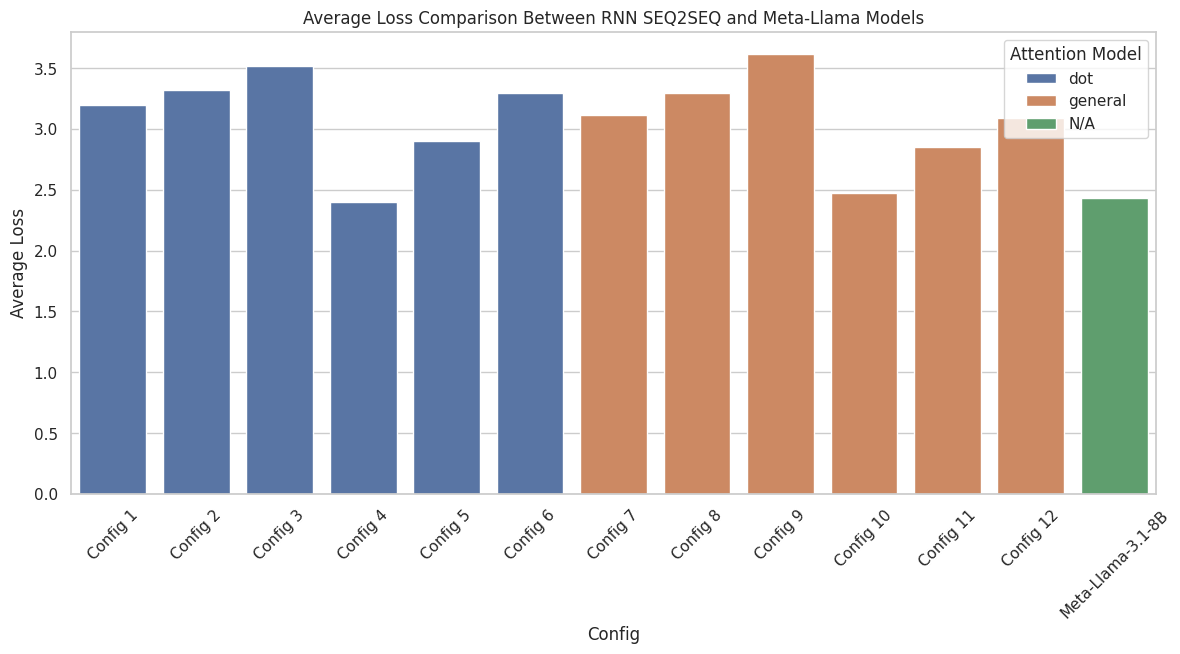

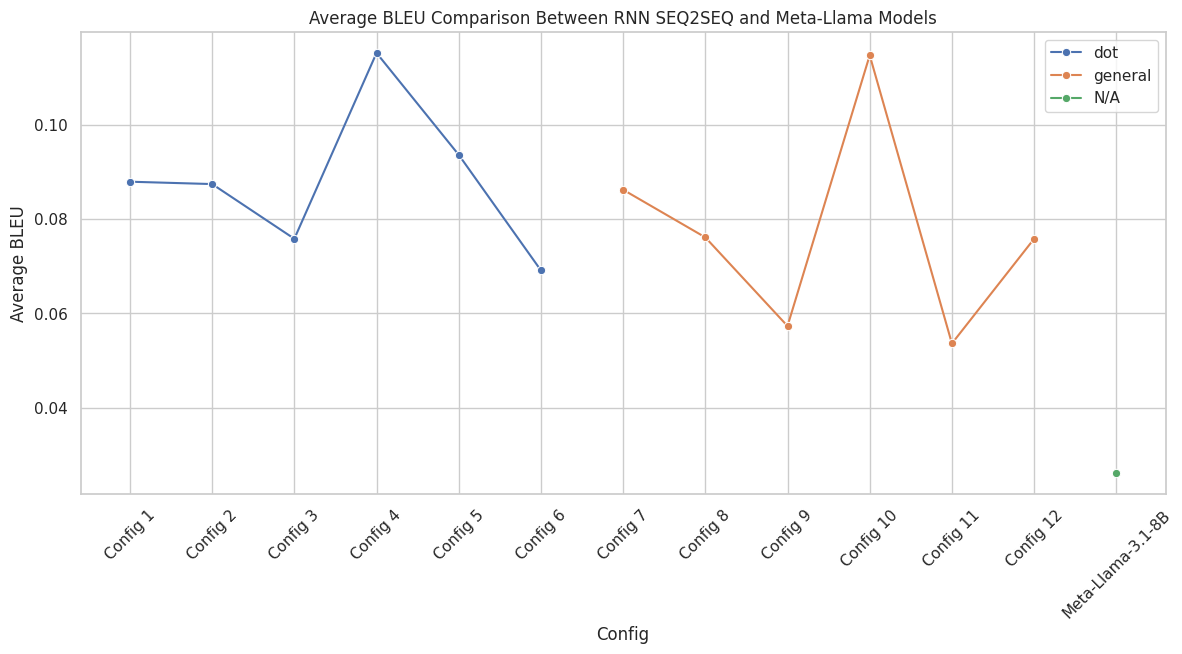

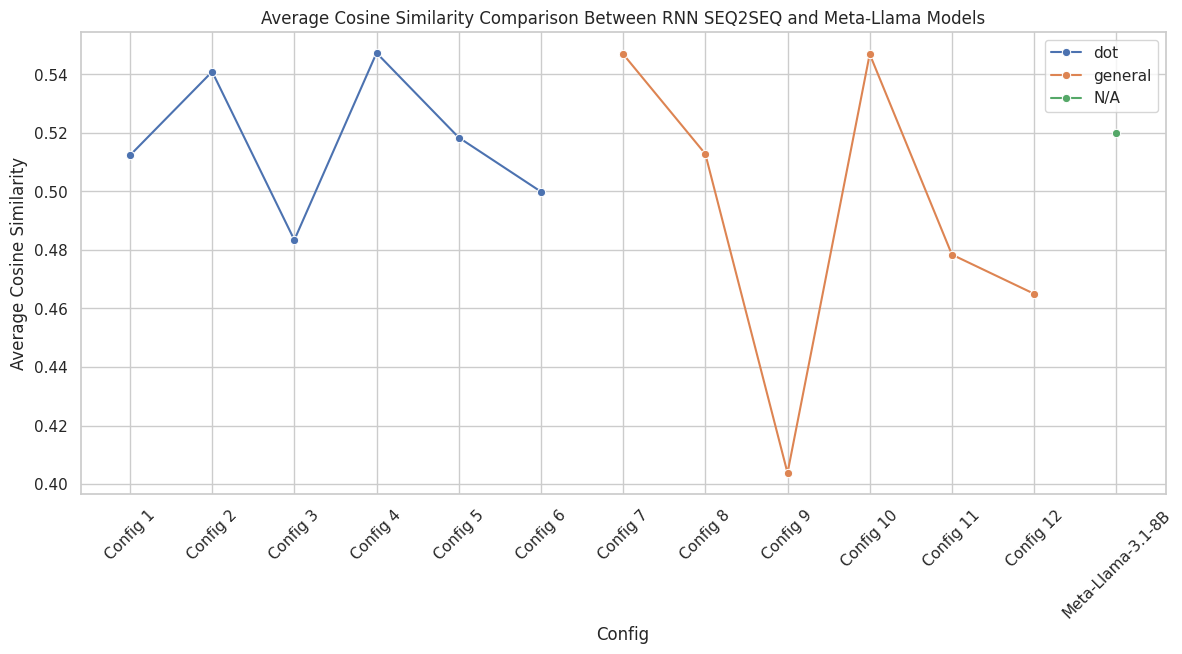

In [31]:
# Combine the two dataframes for plotting
combined_df = pd.concat([rnn_df, llama_df], ignore_index=True)

plt.figure(figsize=(14, 6))

# Bar plot for Average Loss
sns.barplot(data=combined_df, x="Config", y="Average Loss", hue="Attention Model", dodge=False)
plt.title("Average Loss Comparison Between RNN SEQ2SEQ and Meta-Llama Models")
plt.xticks(rotation=45)

# Plot the BLEU score and Cosine similarity as lines
for metric in ["Average BLEU", "Average Cosine Similarity"]:
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=combined_df, x="Config", y=metric, hue="Attention Model", marker="o")
    plt.title(f"{metric} Comparison Between RNN SEQ2SEQ and Meta-Llama Models")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
